In [863]:
# Import relevant libraries
from scipy import stats
import scipy as sp
import pandas as pd
import numpy as np
import random
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import CoxPHFitter
from pandas.core import datetools
import statsmodels.api as sm

# Set seed for any random operations
random.seed(1)

In [864]:
# Import models
%store -r loss_model
%store -r cph

In [865]:
# Read in test dataset, read in random test/train data to ensure consistency with columns
random_test_data = pd.read_csv("random_hazard_test0314.csv")
sorted_test_data = pd.read_csv("sorted_hazard_test0314.csv")
train_data = pd.read_csv("random_hazard_train0314.csv")
print "Number of test points:", sorted_test_data.shape[0]

Number of test points: 5481


In [866]:
#x_train_approval_date = train_data['ApprovalDate'].tolist()
x_test_approval_date = sorted_test_data['ApprovalDate'].tolist()

In [867]:
# Do the usual filtering and matching to train data
c = sorted_test_data.columns.tolist()
c.remove('LoanStatus')
c.remove('ChargeOffDate')
c.remove('GrossChargeOffAmount')
c.remove('BorrZip')
c.remove('CDC_Zip')
c.remove('BorrCity')

c.remove('BorrState')
c.remove('CDC_State')
c.remove('ThirdPartyLender_State')
c.remove('ProjectState')

c.remove('CDC_City')
c.remove('ProjectCounty')
c.remove('ThirdPartyLender_City')
c.remove('ApprovalDate')

x_train = train_data[c]
print x_train.columns.tolist()
x_train = pd.get_dummies(x_train).astype(float)
print x_train.shape

x_test = sorted_test_data[c]
x_test['2DigitNaics'] = x_test['2DigitNaics'].astype(str)
print x_test.columns.tolist()
x_test = pd.get_dummies(x_test).astype(float)
print x_test.shape

x_test['subpgmdesc_Sec. 504 - Delta loans, funded 9/26/95'] = 0.0
x_test['2DigitNaics_MI'] = 0.0
# Reorder columns to match that of random test data
x_test = x_test[['GrossApproval', 'ApprovalFiscalYear', 'TermInMonths', 'SP500_Yearly_Return', 'CPI', 'Yearly_Unemployment_Rate', 'Log_GrossApproval_Norm', 'Log_Yearly_Unemployment_Rate_Norm', 'Log_HPI_Norm', 'ThirdPartyDollars_Norm', 'TermMultipleYear', 'RepeatBorrower', 'BankStateneqBorrowerState', 'ProjectStateneqBorrowerState', 'DaysToDefault', 'Default?', 'DeliveryMethod_504', 'DeliveryMethod_504REFI', 'DeliveryMethod_ALP', 'DeliveryMethod_PCLP', 'subpgmdesc_504 Refinance', 'subpgmdesc_Sec. 504 - Delta loans, funded 9/26/95', 'subpgmdesc_Sec. 504 - Loan Guarantees - Private Sector Financed', 'subpgmdesc_Sec. 504 - Premier Certified Lender Program', 'BusinessType_CORPORATION', 'BusinessType_INDIVIDUAL', 'BusinessType_MISSING', 'BusinessType_PARTNERSHIP', '2DigitNaics_11', '2DigitNaics_21', '2DigitNaics_22', '2DigitNaics_23', '2DigitNaics_31', '2DigitNaics_32', '2DigitNaics_33', '2DigitNaics_42', '2DigitNaics_44', '2DigitNaics_45', '2DigitNaics_48', '2DigitNaics_49', '2DigitNaics_51', '2DigitNaics_52', '2DigitNaics_53', '2DigitNaics_54', '2DigitNaics_55', '2DigitNaics_56', '2DigitNaics_61', '2DigitNaics_62', '2DigitNaics_71', '2DigitNaics_72', '2DigitNaics_81', '2DigitNaics_MI']]

x_test_rand = random_test_data[c]
print x_test_rand.columns.tolist()
x_test_rand = pd.get_dummies(x_test_rand).astype(float)
print x_test_rand.shape

print "DIFFERENCE IN COLUMNS:"
print set(x_test.columns.tolist()) - set(x_test_rand.columns.tolist())

['GrossApproval', 'ApprovalFiscalYear', 'DeliveryMethod', 'subpgmdesc', 'TermInMonths', 'BusinessType', 'SP500_Yearly_Return', 'CPI', 'Yearly_Unemployment_Rate', 'Log_GrossApproval_Norm', 'Log_Yearly_Unemployment_Rate_Norm', 'Log_HPI_Norm', 'ThirdPartyDollars_Norm', 'TermMultipleYear', 'RepeatBorrower', 'BankStateneqBorrowerState', 'ProjectStateneqBorrowerState', '2DigitNaics', 'DaysToDefault', 'Default?']
(43844, 54)
['GrossApproval', 'ApprovalFiscalYear', 'DeliveryMethod', 'subpgmdesc', 'TermInMonths', 'BusinessType', 'SP500_Yearly_Return', 'CPI', 'Yearly_Unemployment_Rate', 'Log_GrossApproval_Norm', 'Log_Yearly_Unemployment_Rate_Norm', 'Log_HPI_Norm', 'ThirdPartyDollars_Norm', 'TermMultipleYear', 'RepeatBorrower', 'BankStateneqBorrowerState', 'ProjectStateneqBorrowerState', '2DigitNaics', 'DaysToDefault', 'Default?']
(5481, 50)
['GrossApproval', 'ApprovalFiscalYear', 'DeliveryMethod', 'subpgmdesc', 'TermInMonths', 'BusinessType', 'SP500_Yearly_Return', 'CPI', 'Yearly_Unemployment_Ra

/Users/michellezhang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [868]:
# to get consistent feature dimensions for both train and test dataset
def add_missing_dummy_columns(d1, d2):
    missing_cols = set(d1.columns) - set(d2.columns)
    for c in missing_cols:
        d2[c] = 0
    return d2

print 'before fix columns: '
print x_train.shape
print x_test.shape

def fix_columns(x_train, x_test):  

    x_test = add_missing_dummy_columns(x_train, x_test)

    extra_cols = set(x_test.columns) - set(x_train.columns)
    x_test = x_test[x_train.columns]
    return x_test

x_test = fix_columns(x_train, x_test)
print 'after fix columns: '
print x_train.shape
print x_test.shape

before fix columns: 
(43844, 54)
(5481, 52)
after fix columns: 
(43844, 54)
(5481, 54)


In [869]:
# event time simulation for HAZARD MODEL
def get_default_time(distr):
    # sample from a uniform distrbution
    u = np.random.rand()
    val = 1 - np.array(distr.values.tolist())
    min_ind = (np.abs(val-u)).argmin() # get closest index of closest val to u
    return min_ind

# DEBUG statements:
#print("uniform: ", u)
#print "print min index:", min_ind 
#print "val-1:", val[min_ind-1]
#print "val+1:", val[min_ind+1]
#print "val:", val[min_ind]
#print "last val:", val[2781]
#print "diff:", val[min_ind] - u 
#print "days:", idx[min_ind] 

# to use :
# t = get_default_time(x_train_death[15:16].drop(['DaysToDefault','Default?'], axis = 1))
# returns number of days - can be saved in duration column for predicting loss ratio

In [870]:
# Number of simulations we want
N = 1000

In [871]:
# Calculates loss of a loan using loss distribution model,
# assuming model is stored in loss_model
def calculate_loss(loan, default_time):
    gross_approval = loan['GrossApproval'].iloc[0]
    loan.at[1, 'DaysToDefault'] = default_time
    loss_ratio = loss_model.predict(loan.drop(['GrossApproval', 'Log_GrossApproval_Norm','Default?', '2DigitNaics_92', '2DigitNaics_99'], axis = 1)).iloc[0]
    pred = max(0, loss_ratio)
    return pred * gross_approval
    #return loss_ratio * gross_approval

In [872]:
from datetime import datetime

start_date = datetime.strptime("2013-02-01", "%Y-%m-%d")
end_1_year = datetime.strptime("2014-02-01", "%Y-%m-%d")
end_5_year = datetime.strptime("2018-02-01", "%Y-%m-%d")

In [873]:
example_date = datetime.strptime(x_test_approval_date[3], "%Y-%m-%d")
default_time = 1000
before_start_date = datetime.strptime("2013-01-31", "%Y-%m-%d")
valid_date = datetime.strptime("2013-03-15", "%Y-%m-%d")
past_end_date = datetime.strptime("2014-02-02", "%Y-%m-%d")
print "1 yr period duration:", (end_1_year - start_date).days 
print "5 yr period duration:", (end_5_year - start_date).days 
print "example diff:", (end_1_year - example_date).days - default_time
print "diff when before start date:", (end_1_year - before_start_date).days
print "diff when a valid date within loan period:", (end_1_year - valid_date).days
print "diff when past end date:", (end_1_year - past_end_date).days

1 yr period duration: 365
5 yr period duration: 1826
example diff: 1732
diff when before start date: 366
diff when a valid date within loan period: 323
diff when past end date: -1


In [874]:
# decide if a default time (in terms of duration since conception of loan)
# actually falls within the time range we are looking at for the 
# loss distribution
#
# calculation:
# for 1 year, there are 365 days between the start and end date of the loan period 
# for 5 years, there are 1826 days between the start and end date of the loan period
# ^this value is encapsulated within period_duration already
# 
# default_time gives when the loan will default in number of days after loan origination
# find (end_date - approval_date) - default_time
# if this value is negative, the default time is past the end date
# if this value is greater than period_duration, the default time is before the start date
# else, this value defaults within our time range
#
# SEE SAMPLE CALCULATIONS ONE CELL ABOVE
def within_default_range(approval_date, end_date, default_time, period_duration):
    diff = (end_date - approval_date).days - default_time
    if 0 <= diff <= period_duration:
        return True
    return False

In [875]:
# Simulates total loss of 500 loans for a t year horizon
def simulate_total_loss(N, year):
    end_date = end_1_year
    period_duration = 365
    if year == 5:
        end_date = end_5_year
        period_duration = 1826
    
    total_losses = []
    total_loan_amounts = []
    for n in range(0, N):
        sampled_loans = x_test.sample(500)
        # precalculate survival distributions
        sampled_loans_distributions = cph.predict_survival_function(sampled_loans.drop(['GrossApproval', 'DaysToDefault','Default?'], axis = 1))
        idx = np.array(sampled_loans_distributions.index.tolist())
        cur_loss = 0.0
        
        for i in range(0, 500):
            cur_loan = sampled_loans[i:i+1]
            approval_date = datetime.strptime(x_test_approval_date[i], "%Y-%m-%d")
            default_time = idx[get_default_time(sampled_loans_distributions.iloc[:,i])]
            if within_default_range(approval_date, end_date, default_time, period_duration):
                loan_loss = calculate_loss(cur_loan.copy(), default_time)
                cur_loss += loan_loss
        
        total_losses.append(cur_loss)
        total_loan_amounts.append(sampled_loans['GrossApproval'].sum())
    
    return total_losses, total_loan_amounts

In [876]:
# QUESTION: Should we remove samples where no loans have defaulted? Are we focused on 
# only loan pools that have defaults or all loan pools in general?

In [877]:
# Estimate for 1 year and plot histogram
total_1_year_losses, total_1_year_loan_amounts = simulate_total_loss(N, 1)
print "Done!"

Done!


In [878]:
# Repeat for 5 year and plot histogram
total_5_year_losses, total_5_year_loan_amounts = simulate_total_loss(N, 5)
print "Done!"

Done!


In [879]:
# Scale in terms of tens of millions
scaled_1_year_loss = [x / 1e7 for x in total_1_year_losses]
scaled_5_year_loss = [x / 1e7 for x in total_5_year_losses]

In [880]:
# Calculate VaR of sorted list of values
def get_VAR(sorted_losses, level):
    index = int((1-level) * 500)
    return sorted_losses[index]

In [881]:
# Calculate Average VaR of sorted list of values
def get_avg_VAR(sorted_losses, level):
    index = int((1-level) * 500)
    return np.mean(sorted_losses[:index+1])

In [882]:
# Calculate confidence interval
def get_conf_interval(sample, level=0.95):
    n, min_max, mean, var, skew, kurt = stats.describe(sample)
    std = math.sqrt(var)
    return stats.norm.interval(level, loc=mean, scale=std)

In [883]:
# Bootstrap to calculate VaR and Average VaR with confidence intervals
def bootstrap_vars(N, total_losses, level=0.95):
    losses_df = pd.Series(total_losses)
    VaR_samples = []
    AVaR_samples = []
    
    for i in range(0, N):
        bootstrap_sample = sorted(losses_df.sample(500, replace=True).tolist())
        VaR = get_VAR(bootstrap_sample, level)
        AVaR = get_avg_VAR(bootstrap_sample, level)
        VaR_samples.append(VaR)
        AVaR_samples.append(AVaR)
    
    print "VaR estimate (mean):", np.mean(VaR_samples)
    print "Average VaR estimate (mean):", np.mean(AVaR_samples)
    print "VaR confidence interval:", get_conf_interval(VaR_samples, level)
    print "AVaR confidence interval:", get_conf_interval(AVaR_samples, level)

In [884]:
# Number of bootstrap simulations
B = 1000

# Print results
print "1-year loss at 95% level:"
bootstrap_vars(B, scaled_1_year_loss, 0.95)
print ""
print "1-year loss at 99% level:"
bootstrap_vars(B, scaled_1_year_loss, 0.99)
print ""
print "5-year loss at 95% level:"
bootstrap_vars(B, scaled_5_year_loss, 0.95)
print ""
print "5-year loss at 99% level:"
bootstrap_vars(B, scaled_5_year_loss, 0.99)

1-year loss at 95% level:
VaR estimate (mean): 1.45435673406
Average VaR estimate (mean): 1.31608722205
VaR confidence interval: (1.3889333513315174, 1.5197801167899456)
AVaR confidence interval: (1.2487868858264544, 1.3833875582728234)

1-year loss at 99% level:
VaR estimate (mean): 1.24236046935
Average VaR estimate (mean): 1.1591442089
VaR confidence interval: (1.1343085588687574, 1.3504123798387431)
AVaR confidence interval: (1.0005823315547482, 1.3177060862493137)

5-year loss at 95% level:
VaR estimate (mean): 4.20169272754
Average VaR estimate (mean): 3.94399637599
VaR confidence interval: (4.062014722212254, 4.3413707328662756)
AVaR confidence interval: (3.8171747566653784, 4.0708179953119901)

5-year loss at 99% level:
VaR estimate (mean): 3.78464604168
Average VaR estimate (mean): 3.64703637067
VaR confidence interval: (3.5076079686122008, 4.0616841147560248)
AVaR confidence interval: (3.4118906590148002, 3.8821820823217723)


In [885]:
# Find junior [5%, 15%] and senior tranches [15%, 100%] for 1 year
junior_tranche_1 = []
senior_tranche_1 = []

for i in range(0, N):
    loan_amount = total_1_year_loan_amounts[i]
    loss_amount = total_1_year_losses[i]
    
    loss_percentage = float(loss_amount) / loan_amount
    junior_loss_percentage = 0.0
    senior_loss_percentage = 0.0
    
    # Loss for junior tranche
    if loss_percentage >= 0.05:
        if loss_percentage >= 0.15:
            junior_loss_percentage = 1.0  # Lost it all
        else:
            junior_loss_percentage = (loss_percentage - 0.05) / (0.15 - 0.05)
    
    # Loss for senior tranche
    if loss_percentage >= 0.15:
        if loss_percentage >= 1.0:
            senior_loss_percentage = 1.0  # Lost it all
        else:
            senior_loss_percentage = (loss_percentage - 0.15) / (1.0 - 0.15)
        
    junior_tranche_1.append(junior_loss_percentage * 100)
    senior_tranche_1.append(senior_loss_percentage * 100)

In [886]:
# Repeat for 5 year
junior_tranche_5 = []
senior_tranche_5 = []

for i in range(0, N):
    loan_amount = total_5_year_loan_amounts[i]
    loss_amount = total_5_year_losses[i]
    
    loss_percentage = float(loss_amount) / loan_amount
    junior_loss_percentage = 0.0
    senior_loss_percentage = 0.0
    
    # Loss for junior tranche
    if loss_percentage >= 0.05:
        if loss_percentage >= 0.15:
            junior_loss_percentage = 1.0  # Lost it all
        else:
            junior_loss_percentage = (loss_percentage - 0.05) / (0.15 - 0.05)
    
    # Loss for senior tranche
    if loss_percentage >= 0.15:
        if loss_percentage >= 1.0:
            senior_loss_percentage = 1.0  # Lost it all
        else:
            senior_loss_percentage = (loss_percentage - 0.15) / (1.0 - 0.15)
        
    junior_tranche_5.append(junior_loss_percentage * 100)
    senior_tranche_5.append(senior_loss_percentage * 100)

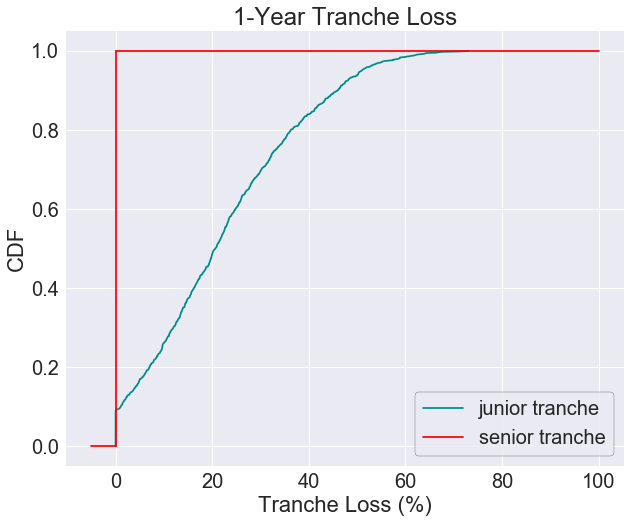

In [887]:
# Plot junior and senior tranche CDFs
junior_sorted_1 = np.sort(junior_tranche_1) 
senior_sorted_1 = np.sort(senior_tranche_1) 
cdf = 1. * np.arange(len(junior_sorted_1)) / (len(junior_sorted_1) - 1)

fig = plt.figure(figsize=(10,8))
plt.plot(junior_sorted_1, cdf, label="junior tranche", color="darkcyan")
plt.plot(senior_sorted_1, cdf, label="senior tranche", color="red")
#Manually plot rest of CDF
plt.plot(np.arange(0, 101), [1] * 101, color="red")
plt.plot(np.arange(-5, 1), [0] * 6, color="red")
plt.ylabel('CDF')
plt.xlabel('Tranche Loss (%)')
plt.title('1-Year Tranche Loss')
plt.grid(True)
plt.legend(loc='lower right', frameon=True, edgecolor="black")

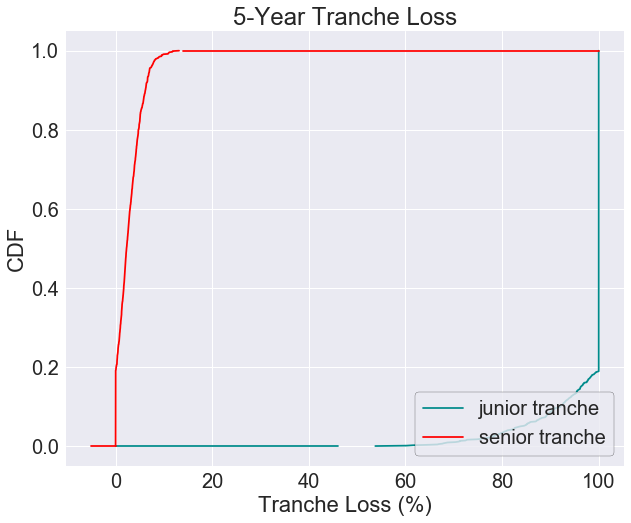

In [888]:
# Plot junior and senior tranche CDFs
junior_sorted_5 = np.sort(junior_tranche_5) 
senior_sorted_5 = np.sort(senior_tranche_5) 
cdf = 1. * np.arange(len(junior_sorted_5)) / (len(junior_sorted_5) - 1)

fig = plt.figure(figsize=(10,8))
plt.plot(junior_sorted_5, cdf, label="junior tranche", color="darkcyan")
plt.plot(senior_sorted_5, cdf, label="senior tranche", color="red")
plt.plot(np.arange(0, 47), [0] * 47, color="darkcyan")
plt.plot(np.arange(14, 101), [1] * 87, color="red")
plt.plot(np.arange(-5, 1), [0] * 6, color="red")

plt.ylabel('CDF')
plt.xlabel('Tranche Loss (%)')
plt.title('5-Year Tranche Loss')
plt.grid(True)
plt.legend(loc='lower right', frameon=True, edgecolor="black")

Total 5-yr loan amount: 317039019.892
Total 1-yr loan amount: 316300082.566
Total 5-yr loss amount: 54216589.1079
Total 1-yr loss amount: 22749220.8366
Scaled versions:
31.7039019892
31.6300082566


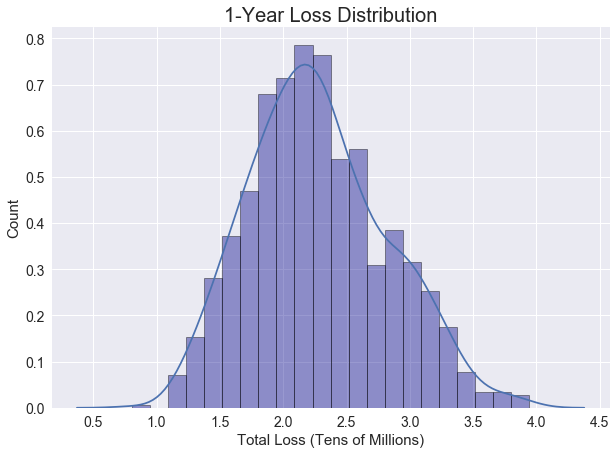

In [889]:
# Plot l-year loss histogram
sns.set_style("darkgrid")
plt.figure(figsize=(10, 7))
g = sns.distplot(scaled_1_year_loss, hist_kws=dict(edgecolor="k", linewidth=1, color="darkblue"))
sns.despine()
g.axes.set_title('1-Year Loss Distribution', fontsize=20, alpha=1.0)
g.axes.set_xlabel('Total Loss (Tens of Millions)', fontsize=15)
g.tick_params(labelsize=14)
g.axes.set_ylabel('Count', fontsize=15)

print "Total 5-yr loan amount:", np.mean(total_5_year_loan_amounts)
print "Total 1-yr loan amount:", np.mean(total_1_year_loan_amounts)
print "Total 5-yr loss amount:", np.mean(total_5_year_losses)
print "Total 1-yr loss amount:", np.mean(total_1_year_losses)
print "Scaled versions:"
print np.mean(total_5_year_loan_amounts) / 1e7
print np.mean(total_1_year_loan_amounts) / 1e7

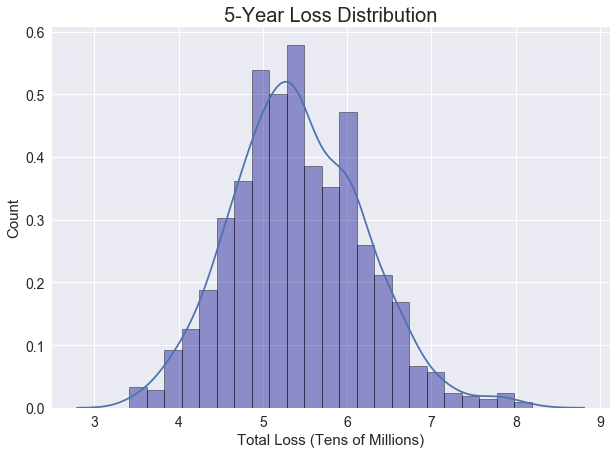

In [890]:
# Plot 5-year loss histogram
sns.set_style("darkgrid")
plt.figure(figsize=(10, 7))
g2 = sns.distplot(scaled_5_year_loss, hist_kws=dict(edgecolor="k", linewidth=1, color="darkblue"))
sns.despine()
g2.axes.set_title('5-Year Loss Distribution', fontsize=20, alpha=1.0)
g2.axes.set_xlabel('Total Loss (Tens of Millions)', fontsize=15)
g2.tick_params(labelsize=14)
g2.axes.set_ylabel('Count', fontsize=15)

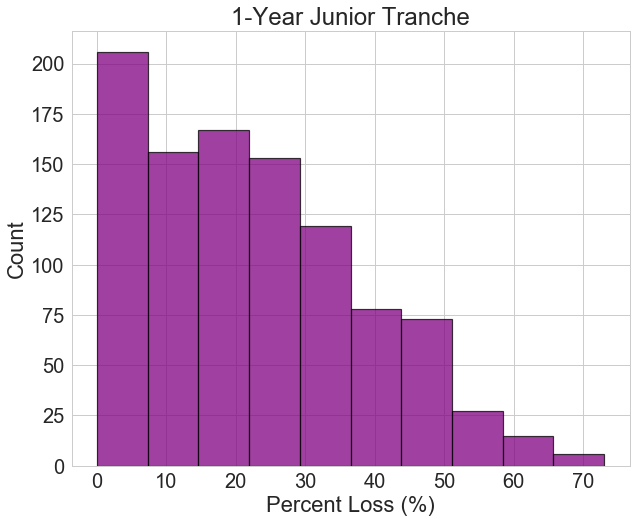

In [891]:
# Plot junior histogram
#sns.set_style("white")
#j = sns.distplot(junior_tranche_1, hist_kws=dict(edgecolor="k", linewidth=1))
#sns.despine()
#j.axes.set_title('1-Year Junior Tranche', fontsize=20, alpha=0.7)
#j.axes.set_xlabel('Percent Loss', fontsize=15)
#j.tick_params(labelsize=14)
#j.axes.set_ylabel('Count', fontsize=15)
sns.set_style("whitegrid")
plt.figure(figsize=(10,8))
plt.hist(junior_tranche_1, facecolor='purple', edgecolor="black", linewidth=1.2, alpha=0.75)
plt.xlabel('Percent Loss (%)')
plt.ylabel('Count')
plt.title('1-Year Junior Tranche')
plt.grid(True)

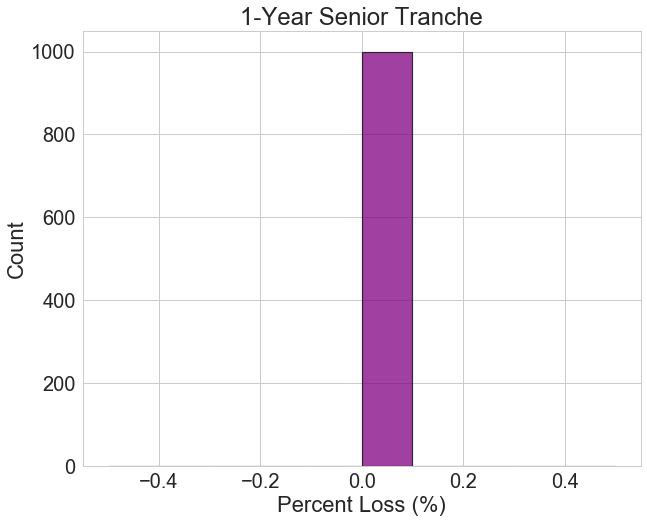

In [892]:
# Plot senior histogram
#j = sns.distplot(senior_tranche_1, hist_kws=dict(edgecolor="k", linewidth=1))
#sns.despine()
#j.axes.set_title('1-Year Seniorr Tranche', fontsize=20, alpha=0.7)
#j.axes.set_xlabel('Percent Loss', fontsize=15)
#j.tick_params(labelsize=14)
#j.axes.set_ylabel('Count', fontsize=15)
plt.figure(figsize=(10,8))
plt.hist(senior_tranche_1, facecolor='purple', edgecolor="black", linewidth=1.2, alpha=0.75)
plt.xlabel('Percent Loss (%)')
plt.ylabel('Count')
plt.title('1-Year Senior Tranche')
plt.grid(True)

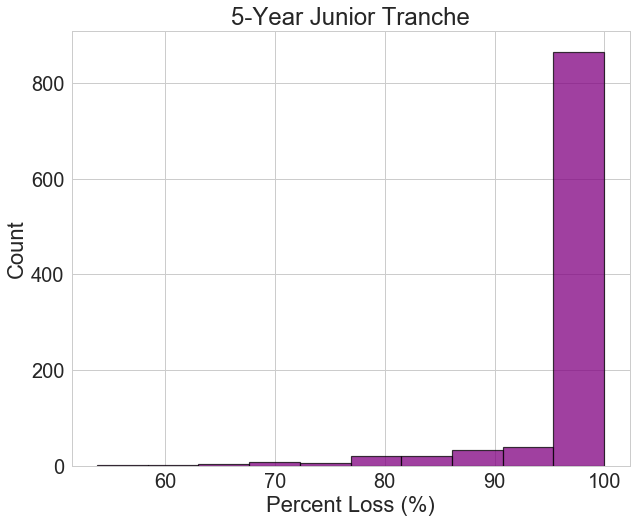

In [893]:
# Plot junior histogram
#j = sns.distplot(junior_tranche_5, hist_kws=dict(edgecolor="k", linewidth=1))
#sns.despine()
#j.axes.set_title('5-Year Junior Tranche', fontsize=20, alpha=0.7)
#j.axes.set_xlabel('Percent Loss', fontsize=15)
#j.tick_params(labelsize=14)
#j.axes.set_ylabel('Count', fontsize=15)
plt.figure(figsize=(10,8))
plt.hist(junior_tranche_5, facecolor='purple', edgecolor="black", linewidth=1.2, alpha=0.75)
plt.xlabel('Percent Loss (%)')
plt.ylabel('Count')
plt.title('5-Year Junior Tranche')
plt.grid(True)

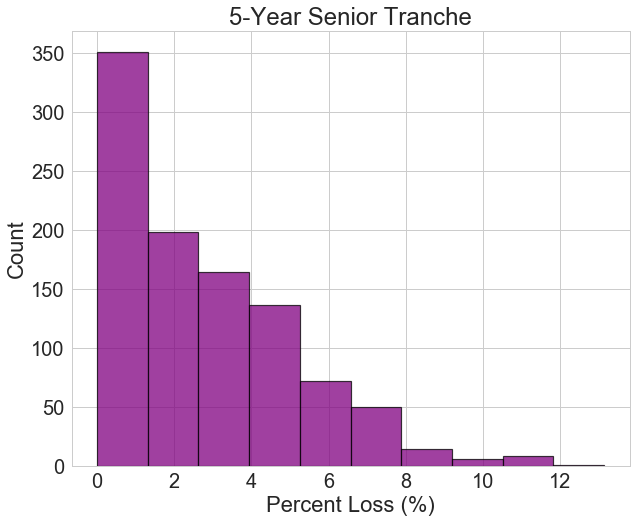

In [894]:
# Plot senior histogram
#s = sns.distplot(senior_tranche_5, hist_kws=dict(edgecolor="k", linewidth=1))
#sns.despine()
#s.axes.set_title('5-Year Senior Tranche', fontsize=20, alpha=0.7)
#s.axes.set_xlabel
#s.axes.set_xlabel('Percent Loss', fontsize=15)
#s.tick_params(labelsize=14)
#s.axes.set_ylabel('Count', fontsize=15)
plt.figure(figsize=(10,8))
plt.hist(senior_tranche_5, facecolor='purple', edgecolor="black", linewidth=1.2, alpha=0.75)
plt.xlabel('Percent Loss (%)')
plt.ylabel('Count')
plt.title('5-Year Senior Tranche')
plt.grid(True)